File descriptions
- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.

Data fields
- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - 상점 ID. unique identifier of a shop
- item_id - 상품 ID. unique identifier of a product
- item_category_id - 상품 카테고리 ID. unique identifier of item category
- item_cnt_day - 당일 판매량. number of products sold. You are predicting a monthly amount of this measure
- item_price - 판매 가격. current price of an item
- date - 날짜. date in format dd/mm/yyyy
- date_block_num - 월 번호. a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - 상품 이름. name of item
- shop_name - 상점 이름. name of shop
- item_category_name - 상품 카테고리 이름. name of item category

In [2]:
import pandas as pd

data_path = 'C:/Users/Admin/Desktop/data'

sales_train = pd.read_csv(data_path + '/sales_train.csv')
shops = pd.read_csv(data_path + '/shops.csv')
items = pd.read_csv(data_path + '/items.csv')
item_categories = pd.read_csv(data_path + '/item_categories.csv')
test = pd.read_csv(data_path + '/test.csv')
submission = pd.read_csv(data_path + '/sample_submission.csv')

In [3]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


분석 결과

1. 월별 판매량 예측이니 '월' 구분자만 있으면 되므로 date_block_num 피처만 있으면 됩니다.

   date 피처는 필요 없으니 제거하겠습니다.

2. 각 상점의 상품별 일일 판매량을 월별로 합친 값이 곧 각 상점의 상품별 월간 판매량입니다.

   즉, 타깃값 = date_block_num 피처 값이 같은 데이터들의 item_cnt_day 값의 합


In [8]:
# DataFrame 행이 1,690,785개 보다 많거나 열이 100개보다 많으면 info() 함수는 비결측값 개수를 출력하지 않습니다.
# sales_train은 행이 2,935,849개라서 기본값으로 info()를 호출하면 비결측값 개수를 출력하지 않습니다.
# 이런 경우에 비결측값 개수를 표시하려면 show_counts 파라미터에 True를 전달하면 됩니다.
sales_train.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date            2935849 non-null  object 
 1   date_block_num  2935849 non-null  int64  
 2   shop_id         2935849 non-null  int64  
 3   item_id         2935849 non-null  int64  
 4   item_price      2935849 non-null  float64
 5   item_cnt_day    2935849 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


분석 결과
1. 모든 피처의 Non-Null 개수가 전체 데이터 수인 2,935,849와 같으므로 모든 피처에 결측값이 하나도 없습니다.
2. 데이터 타입은 object, int64, float64로 다양합니다.
3. 데이터가 300만 개 가까이 돼서 메모리 사용량도 134MB 정도 되므로 메모리 관리가 필요합니다.
4. sales_train 데이터는 2013년 1월부터 2015년 10월까지 판매 내역을 나타낸 시계열 데이터이므로

   2013년 1월부터 2015년 9월까지 판매 내역을 훈련 데이터로 사용하고, 2015년 10월 판매 내역을 검증 데이터로 사용해 보겠습니다.


In [9]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


분석 결과
1. 상점명의 첫 단어는 상점이 위치한 도시를 나타냅니다. 추후 shop_name에서 첫 단어를 추출해 도시 피처를 새로 만들 예정입니다.
2. shops 데이터의 shop_id 피처는 sales_train에도 있는 피처입니다. 그러므로 shop_id를 기준으로 sales_train과 shops를 병합할 수 있습니다.

In [10]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [12]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


분석 결과
1. 상품명은 러시아어인데 상품명에서는 유용한 정보를 얻기 힘들어 모델링할 때 제거할 예정입니다.
2. item_id 피처는 sales_train 데이터에도 존재하는 피처이므로 item_id 피처를 기준으로 sales_train과 items를 병합할 수 있습니다.

In [14]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [16]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


분석 결과
1. sales_train 데이터에는 item_category_id 피처가 보입니다(앞서 items 데이터와 병합 기준).

   그러므로 item_categories 데이터를 기준으로 sales_train과 item_categories를 병합할 수 있습니다.

2. 상품분류명의 첫 단어는 대분류를 뜻하므로 추후 피처 엔지니어링 시 대분류 피처로 만들 예정입니다.


In [17]:
item_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


분석 결과

모든 데이터에 결측값이 없습니다.

* 데이터 병합

   기준이 되는 DataFrame에서 merge() 함수를 호출하고, 병합할 DataFrame을 인수로 넣어주면 됩니다.

   on 파라미터에는 병합 시 기준이 되는 피처를 전달합니다.

   how 파라미터에 'left'를 전달하면 왼쪽 DataFrame의 모든 행을 포함하는 결과를 반환합니다.

In [18]:
train = sales_train.merge(shops, on='shop_id', how='left')
train = train.merge(items, on='item_id', how='left')
train = train.merge(item_categories, on='item_category_id', how='left')

train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,05.01.2013,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,06.01.2013,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,15.01.2013,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства


In [20]:
# 피처 요약표 만들기
def resumetable(df):
    print(f"데이터 프레임 형상: {df.shape}")
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index': '피처'})
    summary['결측값 개수'] = df.isnull().sum()
    summary['고유값 개수'] = df.nunique().values
    summary['첫 번째 값'] = df.loc[0].values
    summary['두 번째 값'] = df.loc[1].values

    return summary

resumetable(train)

데이터 프레임 형상: (2935849, 10)


,피처,데이터 타입,결측값 개수,고유값 개수,첫 번째 값,두 번째 값
0,date,object,NaN,1034,02.01.2013,03.01.2013
1,date_block_num,int64,NaN,34,0,0
2,shop_id,int64,NaN,60,59,25
3,item_id,int64,NaN,21807,22154,2552
4,item_price,float64,NaN,19993,999.0,899.0
5,item_cnt_day,float64,NaN,198,1.0,1.0
6,shop_name,object,NaN,60,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум"""
7,item_name,object,NaN,21807,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP
8,item_category_id,int64,NaN,84,37,58
9,item_category_name,object,NaN,84,Кино - Blu-Ray,Музыка - Винил


분석 결과

각 item, shop, item_cagetory는 id와 name의 고유값 개수가 서로 같으므로 id와 name이 일대일 매칭된다는 것을 알 수 있습니다.
  
따라서 같은 정보를 갖는 두 피처를 함께 사용할 필요가 없으므로 둘 중 하나를 제거할 예정입니다.

다만 name 피처 중 모델링에 도움되는 파생 피처를 만들 수 있는 경우가 있습니다.

# 데이터 시각화

   train에서 식별자나 문자 데이터를 제외하면 item_cnt_day 피처와 item_price 피처만 남습니다.

<Axes: ylabel='item_cnt_day'>

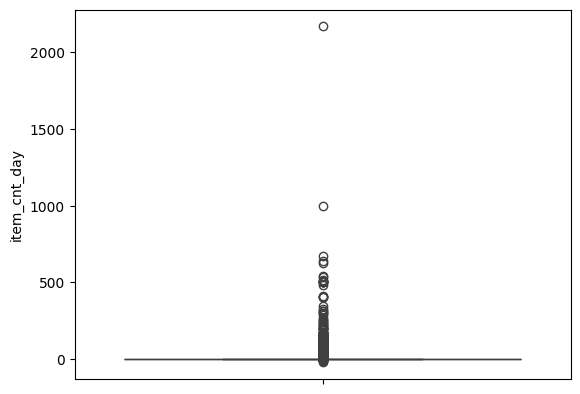

In [21]:
# 일별 판매량 시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

sns.boxplot(y='item_cnt_day', data=train)


분석 결과

일반적인 박스플롯 모양이 나오지 않고 있습니다.

이상치가 많아서 그런데 이상치 범위가 과도하게 넓어서 1사분위 수, 2사분위 수, 3사분위 수를 나타내는 박스 모양이 납작해진 것입니다.

과한 이상치는 제거해야 합니다. 여기서는 item_cnt_day가 1,000 이상인 데이터를 제거할 계획입니다.

<Axes: ylabel='item_price'>

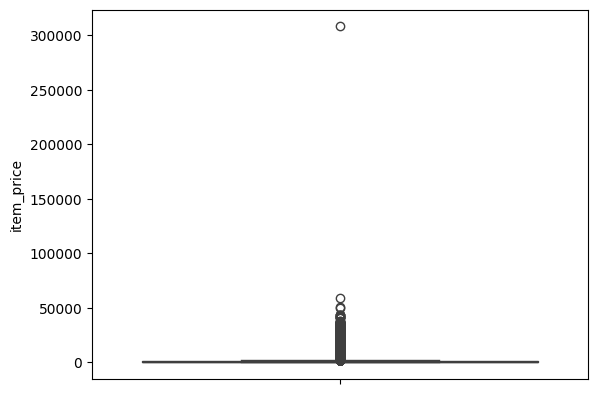

In [22]:
# 판매가(상품 가격) 시각화
sns.boxplot(y='item_price', data=train)

분석 결과

300,000루블(약 450만원)이 넘는 판매가 때문에 이번 박스플롯도 납작합니다.

추후 판매가가 50,000루블 이상인 이상치는 제거하겠습니다.

* 그룹화

   특정 피처를 기준으로 그룹화해 원하는 집곗값을 구하려면 groupby() 함수를 사용합니다.

   train의 date_block_num 피처를 기준으로 그룹화해 item_cnt_day 피처의 합(sum)을 구해 보겠습니다.

   즉, 월별(date_block_num) 월간 판매량(item_cnt_day의 합)을 말합니다.


In [23]:
group = train.groupby('date_block_num').agg({'item_cnt_day': 'sum'})
group.reset_index()  # 인덱스 재설정

,date_block_num,item_cnt_day
0,0,131479.0
1,1,128090.0
2,2,147142.0
3,3,107190.0
4,4,106970.0
5,5,125381.0
6,6,116966.0
7,7,125291.0
8,8,133332.0
9,9,127541.0


- reset_index()를 호출하지 않으면 그룹화한 date_block_num 피처가 인덱스로 설정됩니다.

  그래프를 그릴 때 date_block_num 피처를 사용해야 해서 새로운 인덱스를 만들었습니다.

[Text(0.5, 1.0, 'Distribution of monthly item counts by date block number'),
 Text(0.5, 0, 'Date block number'),
 Text(0, 0.5, 'Monthly item counts')]

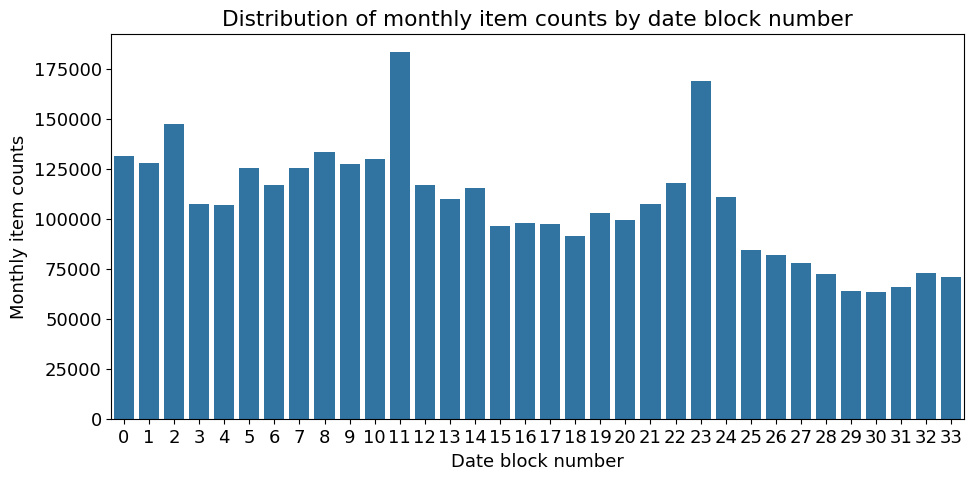

In [25]:
# groupby() 함수를 사용해 월별 판매량 시각화
import matplotlib as mpl

mpl.rc('font', size=13)
figure, ax = plt.subplots()
figure.set_size_inches(11, 5)

# 월별 총 상품 판매량
group_month_sum = train.groupby('date_block_num').agg({'item_cnt_day': 'sum'})
group_month_sum = group_month_sum.reset_index()

# 월별 총 상품 판매량 막대 그래프
sns.barplot(x='date_block_num', y='item_cnt_day', data=group_month_sum)
# 그래프 제목, x축 라벨, y축 라벨명 설정
ax.set(title='Distribution of monthly item counts by date block number',
       xlabel='Date block number',
       ylabel='Monthly item counts')

11일 때와 23일 때 판매량이 가장 많은데, 각각 2013년 12월과 2014년 12월입니다.

연말이라 판매량이 급증한 것으로 보입니다.

In [31]:
train['item_category_id'].nunique()

84

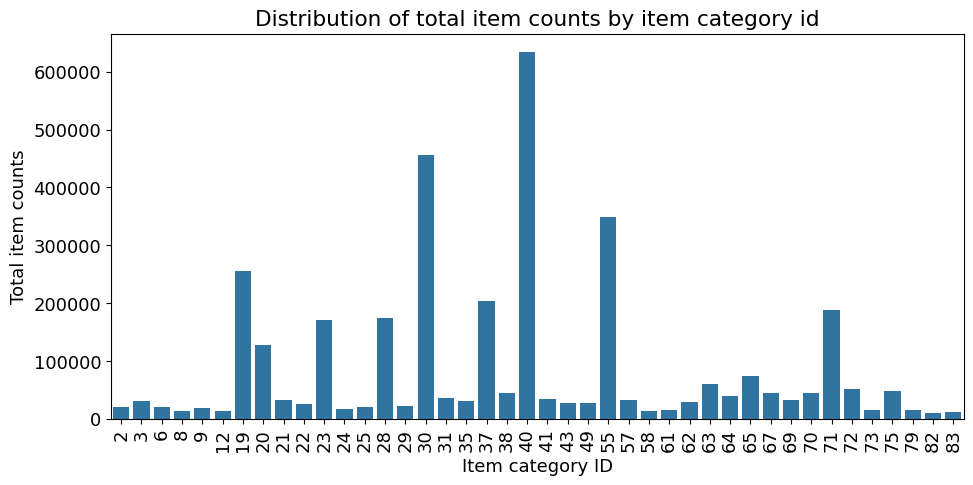

In [29]:
# 상품분류별 판매량
# 상품분류는 총 84개인데 막대 그래프로 한 번에 표한하기에는 너무 많으니 판매량이 10,000개를 초과하는 상품 분류만 추출해서 그려보겠습니다.

figure, ax = plt.subplots()
figure.set_size_inches(11, 5)

# 상품분류별 총 상품 판매량
group_cat_sum = train.groupby('item_category_id').agg({'item_cnt_day': 'sum'})
group_cat_sum = group_cat_sum.reset_index()

# 월간 판매량이 10,000개를 초과하는 상품분류만 추출
group_cat_sum = group_cat_sum[group_cat_sum['item_cnt_day'] > 10000]

# 상품분류별 총 상품 판매량 막대 그래프
sns.barplot(x='item_category_id', y='item_cnt_day', data=group_cat_sum)

# 그래프 제목, x축 라벨, y축 라벨명 설정
ax.set(title='Distribution of total item counts by item category id',
       xlabel='Item category ID',
       ylabel='Total item counts')
ax.tick_params(axis='x', rotation=90)  # x축 라벨 회전

In [32]:
train['shop_id'].nunique()

60

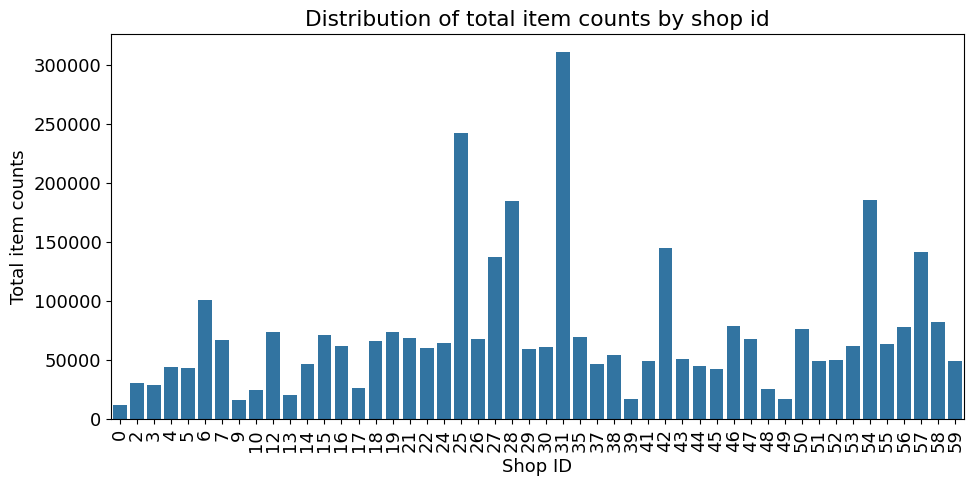

In [33]:
# 상점별 판매량
# 상점 개수는 60개인데 마찬가지로 판매량이 10,000개를 초과하는 상점만 추렸습니다.

figure, ax = plt.subplots()
figure.set_size_inches(11, 5)

# 상점별 총 상품 판매량
group_shop_sum = train.groupby('shop_id').agg({'item_cnt_day': 'sum'})
group_shop_sum = group_shop_sum.reset_index()

# 월간 판매량이 10,000개를 초과하는 상점만 추출
group_shop_sum = group_shop_sum[group_shop_sum['item_cnt_day'] > 10000]

# 상점별 총 상품 판매량 막대 그래프
sns.barplot(x='shop_id', y='item_cnt_day', data=group_shop_sum)

# 그래프 제목, x축 라벨, y축 라벨명 설정
ax.set(title='Distribution of total item counts by shop id',
       xlabel='Shop ID',
       ylabel='Total item counts')
ax.tick_params(axis='x', rotation=90)  # x축 라벨 회전